# Figure 4:
Plot Clim precip bias in obs, cmip, and % error
Plot Clim hur700hPa bias in ....

Figure SXX: Repeat for CRE, SWCRE, WAP, hus500wPa

In [1]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plotting Utils

In [2]:
def _global_plot(
    ax, 
    data, 
    lat, 
    lon, 
    cmap, 
    pvalues=None, 
    right_title="", 
    left_title="", 
    levels=np.arange(-4, 4.1, .1), 
    cbar_label: str = "",
    contours=None,
    pr=None,
    wind=None,
):
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend="both",
        levels=levels,
    )
    if pr is not None:
        ax.contour(
            lon, lat, pr,
            transform=ccrs.PlateCarree(),
            colors="magenta",
            levels=[-6, 6],
        )
    
    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
    
    if wind is not None:
        # Scale reg maps 25 
        # q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], scale=150, headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        # Scale for Pr wind maps
        q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        ax.quiverkey(q, .9, -.15, .25, str(.25) + r' $\frac{m}{s}/\sigma$', labelpos='E', transform=ccrs.PlateCarree(), coordinates='axes')
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Southern ITCZ 
    bound_region(ax, lons=(-130, -80), lats=(-20, 0), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -45, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # add cbar label to top of colorbar
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
    # cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.030, pad=0.02)
    cbar.ax.set_title(cbar_label, fontsize=10)

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )


In [3]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = data.bounds.add_bounds("T")
    return data

def detrend(da):
    print(da.time)
    time_idx = xr.DataArray(np.arange(len(da.time)), dims="time")
    print(da, time_idx)
    slope = xscore.linslope(time_idx, da, dim="time", skipna=False)
    print(slope)
    da = da - slope*time_idx
    print(da)
    return da 


# Load Data

In [4]:
# Create output grid
lat = np.arange(-88.75, 90, 2.5)
lon = np.arange(1.25, 360, 2.5)
output_grid = xc.create_grid(lat, lon)

DATA_DIR = "/home/espinosa10/SO-EP-teleconnection/Data/"

In [5]:
# LOAD CMIP RADIATION AND PRECIPITATION
pr_cmip6 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/pr_mon_1850-2100_CMIP6_piControl.nc")
pr_cmip5 = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/pr_mon_1850-2100_CMIP5_piControl.nc")
pr_cmip =  xr.concat([pr_cmip6, pr_cmip5], dim="model")
pr_cmip_clim = pr_cmip.mean("time")

# SWCRE
cmip6_monthly_swcre = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcre_cmip6_monthly_1850-2000.nc")
cmip5_monthly_swcre = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/swcre_cmip5_monthly_1850-2000.nc")
cmip_monthly_swcre = xr.concat([cmip6_monthly_swcre, cmip5_monthly_swcre], dim="model").mean(["time", "model"])["swcre"]
# LWCRE
cmip6_monthly_lwcre = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/lwcre_cmip6_monthly_1850-2000.nc")
cmip5_monthly_lwcre = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/lwcre_cmip5_monthly_1850-2000.nc")
cmip_monthly_lwcre = xr.concat([cmip6_monthly_lwcre, cmip5_monthly_lwcre], dim="model").mean(["time","model"])["lwcre"]

In [9]:
# LOAD ERA5 RADIATION
if not os.path.exists(os.path.join(DATA_DIR, "era5_swcre_clim.nc")) or not os.path.exists(os.path.join(DATA_DIR, "era5_lwcre_clim.nc")):
    era5_rad = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1940-01_2023-12_tp_radiation.nc")[["tsr", "tsrc", "ttr", "ttrc"]]
    # era5_rad = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/era5_toa_radiation_197901-202412.nc").sel(valid_time=slice("1979-01", "2023-12"))
    era5_rad = era5_rad.rename({"latitude": "lat", "longitude": "lon", "valid_time": "time"})
    era5_rad = detrend(era5_rad)
    era5_rad_clim = era5_rad.mean("time")

    # Calc SWCRE
    era5_toa_sw_clim = era5_rad_clim.regridder.horizontal("tsr", output_grid, tool='xesmf', method='bilinear')
    era5_toa_sw_clear_clim = era5_rad_clim.regridder.horizontal("tsrc", output_grid, tool='xesmf', method='bilinear')
    era5_swcre_clim = (era5_toa_sw_clim["tsr"] - era5_toa_sw_clear_clim["tsrc"]).rename("swcre").to_dataset()
    # Calc LWCRE
    era5_toa_lw_clim = era5_rad_clim.regridder.horizontal("ttr", output_grid, tool='xesmf', method='bilinear')
    era5_toa_lw_clear_clim = era5_rad_clim.regridder.horizontal("ttrc", output_grid, tool='xesmf', method='bilinear')
    era5_lwcre_clim = (era5_toa_lw_clim["ttr"] - era5_toa_lw_clear_clim["ttrc"]).rename("lwcre").to_dataset()

    era5_swcre_clim.to_netcdf(os.path.join(DATA_DIR, "era5_swcre_clim.nc"))
    era5_lwcre_clim.to_netcdf(os.path.join(DATA_DIR, "era5_lwcre_clim.nc"))
else: 
    era5_swcre_clim = xr.open_dataset(os.path.join(DATA_DIR, "era5_swcre_clim.nc"))
    era5_lwcre_clim = xr.open_dataset(os.path.join(DATA_DIR, "era5_lwcre_clim.nc"))

<xarray.DataArray 'time' (time: 1020)>
array(['1940-01-01T06:00:00.000000000', '1940-02-01T06:00:00.000000000',
       '1940-03-01T06:00:00.000000000', ..., '2024-10-01T06:00:00.000000000',
       '2024-11-01T06:00:00.000000000', '2024-12-01T06:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    number   int64 ...
  * time     (time) datetime64[ns] 1940-01-01T06:00:00 ... 2024-12-01T06:00:00
    expver   (time) object ...
Attributes:
    long_name:      time
    standard_name:  time
<xarray.Dataset>
Dimensions:  (time: 1020, lat: 721, lon: 1440)
Coordinates:
    number   int64 ...
  * time     (time) datetime64[ns] 1940-01-01T06:00:00 ... 2024-12-01T06:00:00
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
    expver   (time) object ...
Data variables:
    tsr      (time, lat, lon) float32 ...
    tsrc     (time, lat, lon) float32 ...
    ttr      (time, lat, lon) fl

In [7]:
# Regrid Data
# era5_total_precip = fix_coords(xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_total_precipitation.nc"))
era = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1940-01_2023-12_tp_radiation.nc").rename({"valid_time": "time"})
era["time"] = era.time.values.astype('datetime64[M]')
era5_total_precip = fix_coords(era[["tp"]].drop(["expver", "number"]))
era5_total_precip = era5_total_precip.rename({"latitude": "lat", "longitude": "lon"})
era5_total_precip["tp"] = detrend(era5_total_precip["tp"])
era5_total_precip_clim = (era5_total_precip.mean("time")["tp"]*1000).to_dataset()
era5_precip_clim_regrid = era5_total_precip_clim.regridder.horizontal("tp", output_grid, tool='xesmf', method='bilinear')

# I NEED TO CALCULATE STATISTICAL SIGNIFIGANCE BETWEEN GROUP DISTRIBUTIONS
## HUS 500hPa
# era5_hus500 = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/era5_1950-2023_monthly_0.25deg_hus500.nc")
# era5_hus500 = era5_hus500.rename({"latitude": "lat", "longitude": "lon", "q": "hus", "valid_time": "time"}).isel(pressure_level=0)
# era5_hus500["hus"] = detrend(era5_hus500["hus"])
# era5_hus500 = era5_hus500.regridder.horizontal("hus", output_grid, tool='xesmf', method='bilinear')
# era5_hus500_clim = era5_hus500.mean("time")
# era5_hus500_clim

# cmip5_hus500 = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/hus_mon_500hPa-1850-2100_CMIP5_piControl.nc")
# cmip6_hus500 = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/hus_mon_500hPa-1850-2100_CMIP6_piControl.nc")
# cmip_hus500 =  xr.concat([cmip5_hus500, cmip6_hus500], dim="model")
# cmip_hus500_clim = cmip_hus500.mean("time")
# cmip_hus500_clim

## HUR 700hPa
cmip5_hur700 = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/hur_mon_700hPa-1850-2100_CMIP5_piControl.nc")
cmip6_hur700 = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/hur_mon_700hPa-1850-2100_CMIP6_piControl.nc")
cmip_hur700 =  xr.concat([cmip5_hur700, cmip6_hur700], dim="model")
cmip_hur700_clim = cmip_hur700.mean("time")
cmip_hur700_clim

# era5_hur700 = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/era5_1950-2023_monthly_0.25deg_hur700.nc")
era5_hur700 = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1940-01_2023-12_hur_omega_700.nc")
era5_hur700 = era5_hur700.rename({"latitude": "lat", "longitude": "lon", "r": "hur", "valid_time": "time"}).isel(pressure_level=0)
era5_hur700["hur"] = detrend(era5_hur700["hur"])
era5_hur700 = era5_hur700.regridder.horizontal("hur", output_grid, tool='xesmf', method='bilinear')
era5_hur700_clim = era5_hur700.mean("time")

## WAP 700hPa
cmip5_wap700 = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/wap_mon_700hPa-1850-2100_CMIP5_piControl.nc")
cmip6_wap700 = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/wap_mon_700hPa-1850-2100_CMIP6_piControl.nc")
cmip_wap700 =  xr.concat([cmip5_wap700, cmip6_wap700], dim="model")
cmip_wap700_clim = cmip_wap700.mean("time")

# era5_wap700 = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/era5_1950-2023_monthly_0.25deg_omega700.nc")
era5_wap700 = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1940-01_2023-12_hur_omega_700.nc")
era5_wap700 = era5_wap700.rename({"latitude": "lat", "longitude": "lon", "w": "wap", "valid_time": "time"}).isel(pressure_level=0)
era5_wap700["hur"] = detrend(era5_wap700["wap"])
era5_wap700 = era5_wap700.regridder.horizontal("wap", output_grid, tool='xesmf', method='bilinear')
era5_wap700_clim = era5_wap700.mean("time")

<xarray.DataArray 'time' (time: 1020)>
array(['1940-01-01T00:00:00.000000000', '1940-02-01T00:00:00.000000000',
       '1940-03-01T00:00:00.000000000', ..., '2024-10-01T00:00:00.000000000',
       '2024-11-01T00:00:00.000000000', '2024-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2024-12-01
Attributes:
    bounds:   time_bnds
<xarray.DataArray 'tp' (time: 1020, lat: 721, lon: 1440)>
[1059004800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2024-12-01
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
Attributes: (12/32)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits: 

# Figure 4

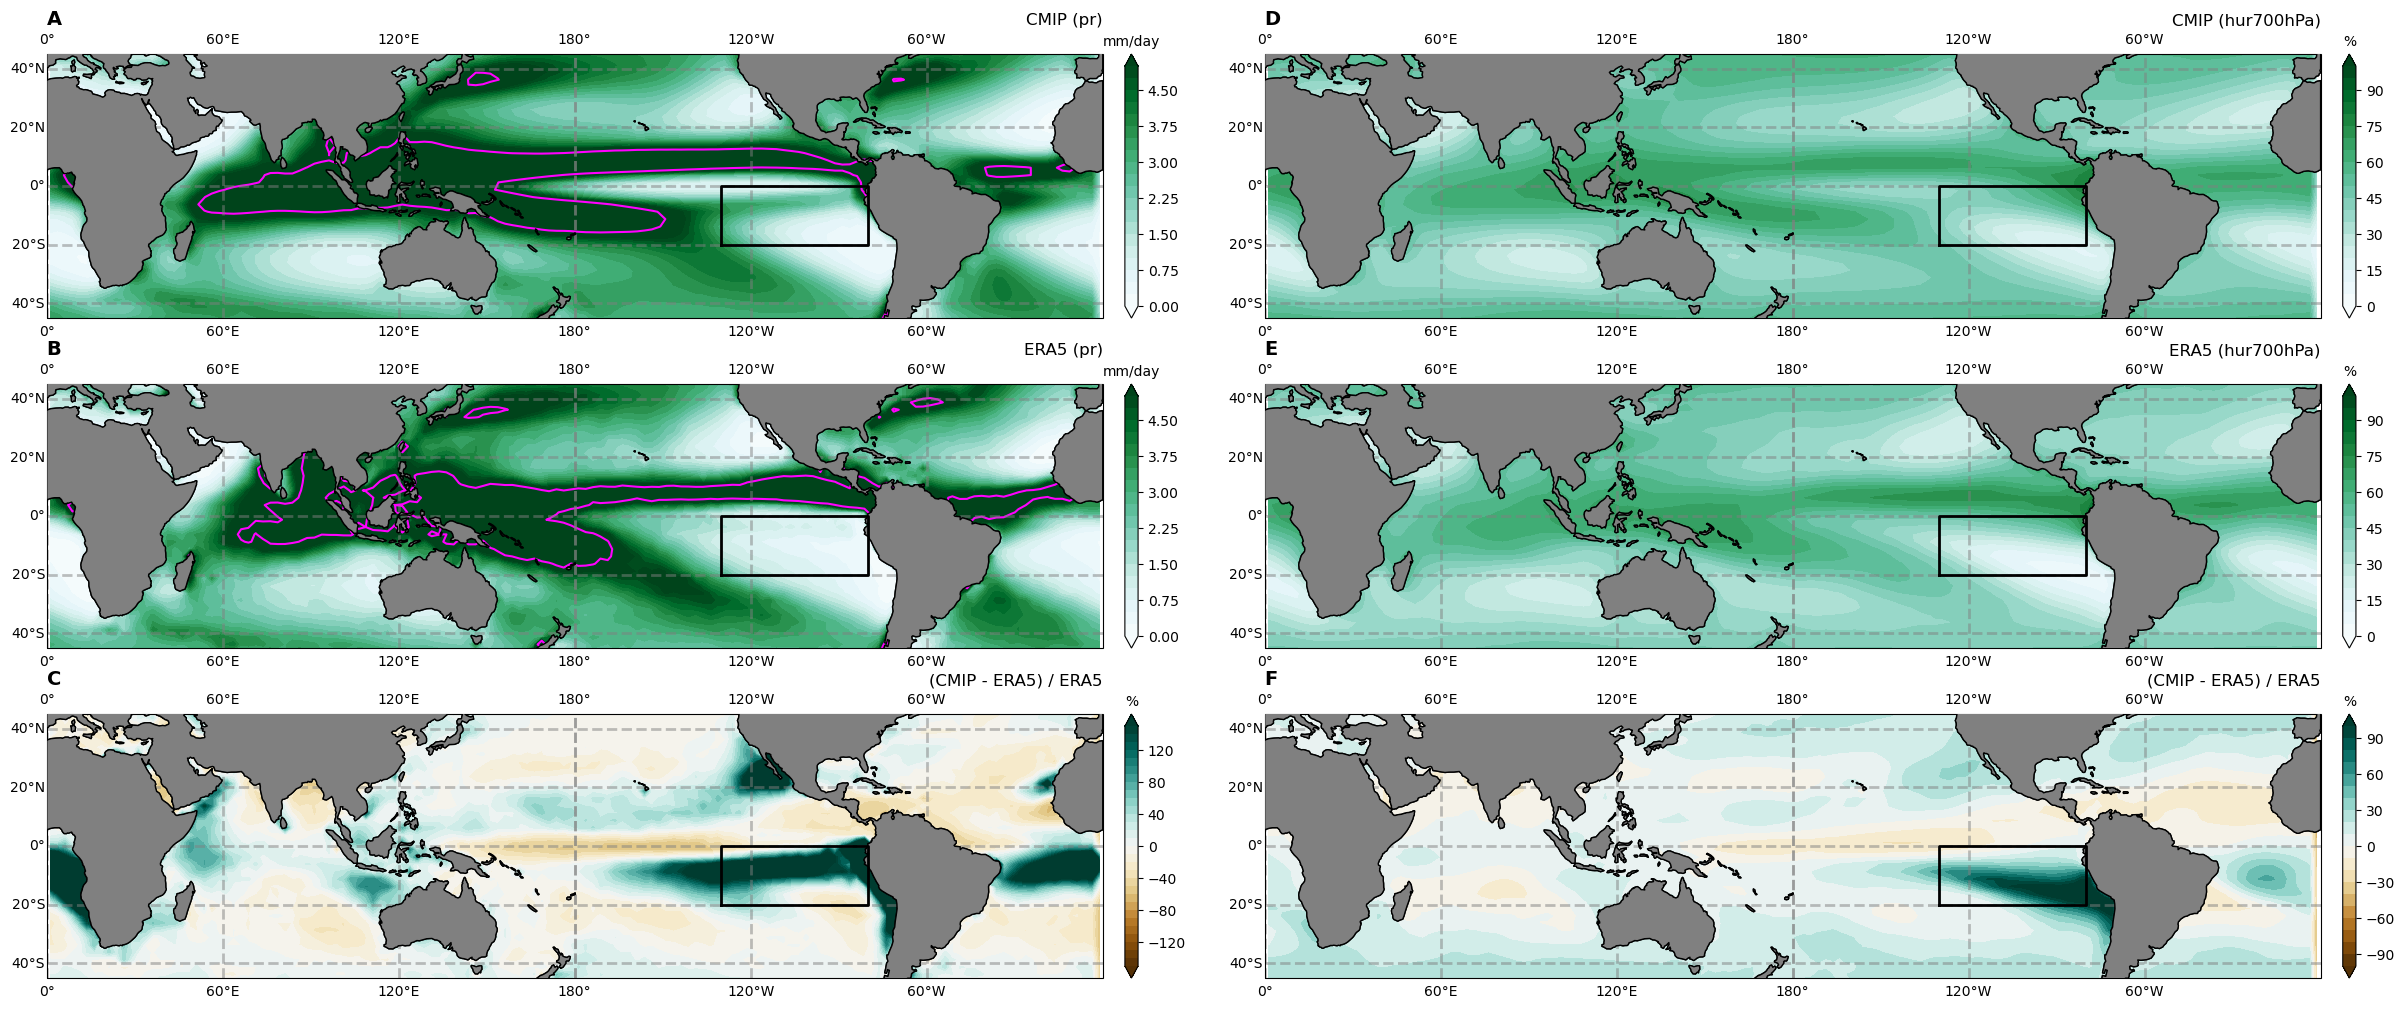

In [8]:
# Create figure and gridspec (3 rows, 2 columns)
fig = plt.figure(figsize=(30, 12))
gs = fig.add_gridspec(3, 2, hspace=0.25, wspace=0.10) 

######## LEFT COLUMN (Precipitation) ########
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # CMIP Precip
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180)) # ERA5 Precip
ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Difference (CMIP - ERA5)

######## RIGHT COLUMN (hur 700hPa) ########
ax4 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=180)) # CMIP hur 700hPa
ax5 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=180)) # ERA5 hur 700hPa
ax6 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=180)) # Difference (CMIP - ERA5)

########### LEFT COLUMN: Precipitation ########
_global_plot(ax1, (pr_cmip_clim.mean("model")["pr"]*86400).values, pr_cmip_clim.lat, pr_cmip_clim.lon, cmap="BuGn", cbar_label="mm/day", levels=np.arange(0, 5.25, 0.25), 
    pr=(pr_cmip_clim.mean("model")["pr"]*86400).values)
ax1.set_title("CMIP (pr)", loc="right", fontsize=12)
ax1.set_title("A", loc="left", fontweight="bold", fontsize=14)

_global_plot(ax2, era5_precip_clim_regrid["tp"].values, era5_precip_clim_regrid.lat, era5_precip_clim_regrid.lon, cmap="BuGn", cbar_label="mm/day", levels=np.arange(0, 5.25, 0.25), 
    pr=era5_precip_clim_regrid["tp"].values)
ax2.set_title("ERA5 (pr)", loc="right", fontsize=12)
ax2.set_title("B", loc="left", fontweight="bold", fontsize=14)

_global_plot(ax3, 100*(((pr_cmip_clim.mean("model")["pr"]*86400) - era5_precip_clim_regrid["tp"]) / era5_precip_clim_regrid["tp"]),
             era5_precip_clim_regrid.lat, era5_precip_clim_regrid.lon, cmap="BrBG", cbar_label="%", levels=np.arange(-150, 160, 10))
ax3.set_title("(CMIP - ERA5) / ERA5", loc="right", fontsize=12)
ax3.set_title("C", loc="left", fontweight="bold", fontsize=14)


########## RIGHT COLUMN: hur 700hPa #########
_global_plot(ax4, cmip_hur700_clim["hur"].mean("model").values, cmip_hur700_clim.lat, cmip_hur700_clim.lon, cmap="BuGn", cbar_label="%", levels=np.arange(0, 105, 5))
ax4.set_title("CMIP (hur700hPa)", loc="right", fontsize=12)
ax4.set_title("D", loc="left", fontweight="bold", fontsize=14)

_global_plot(ax5, era5_hur700_clim["hur"].values, era5_hur700_clim.lat, era5_hur700_clim.lon, cmap="BuGn", cbar_label="%", levels=np.arange(0, 105, 5))
ax5.set_title("ERA5 (hur700hPa)", loc="right", fontsize=12)
ax5.set_title("E", loc="left", fontweight="bold", fontsize=14)

_global_plot(ax6, 100*((cmip_hur700_clim["hur"].mean("model").values - era5_hur700_clim["hur"].values) / era5_hur700_clim["hur"].values), 
             era5_hur700_clim.lat, era5_hur700_clim.lon, cmap="BrBG", cbar_label="%", levels=np.arange(-100, 110, 10))
ax6.set_title("(CMIP - ERA5) / ERA5", loc="right", fontsize=12)
ax6.set_title("F", loc="left", fontweight="bold", fontsize=14)

#########################################################################
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_4_v2.png", dpi=300, bbox_inches="tight")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/Main/Figure_4_v2.pdf", dpi=300, bbox_inches="tight")

# Figure SX

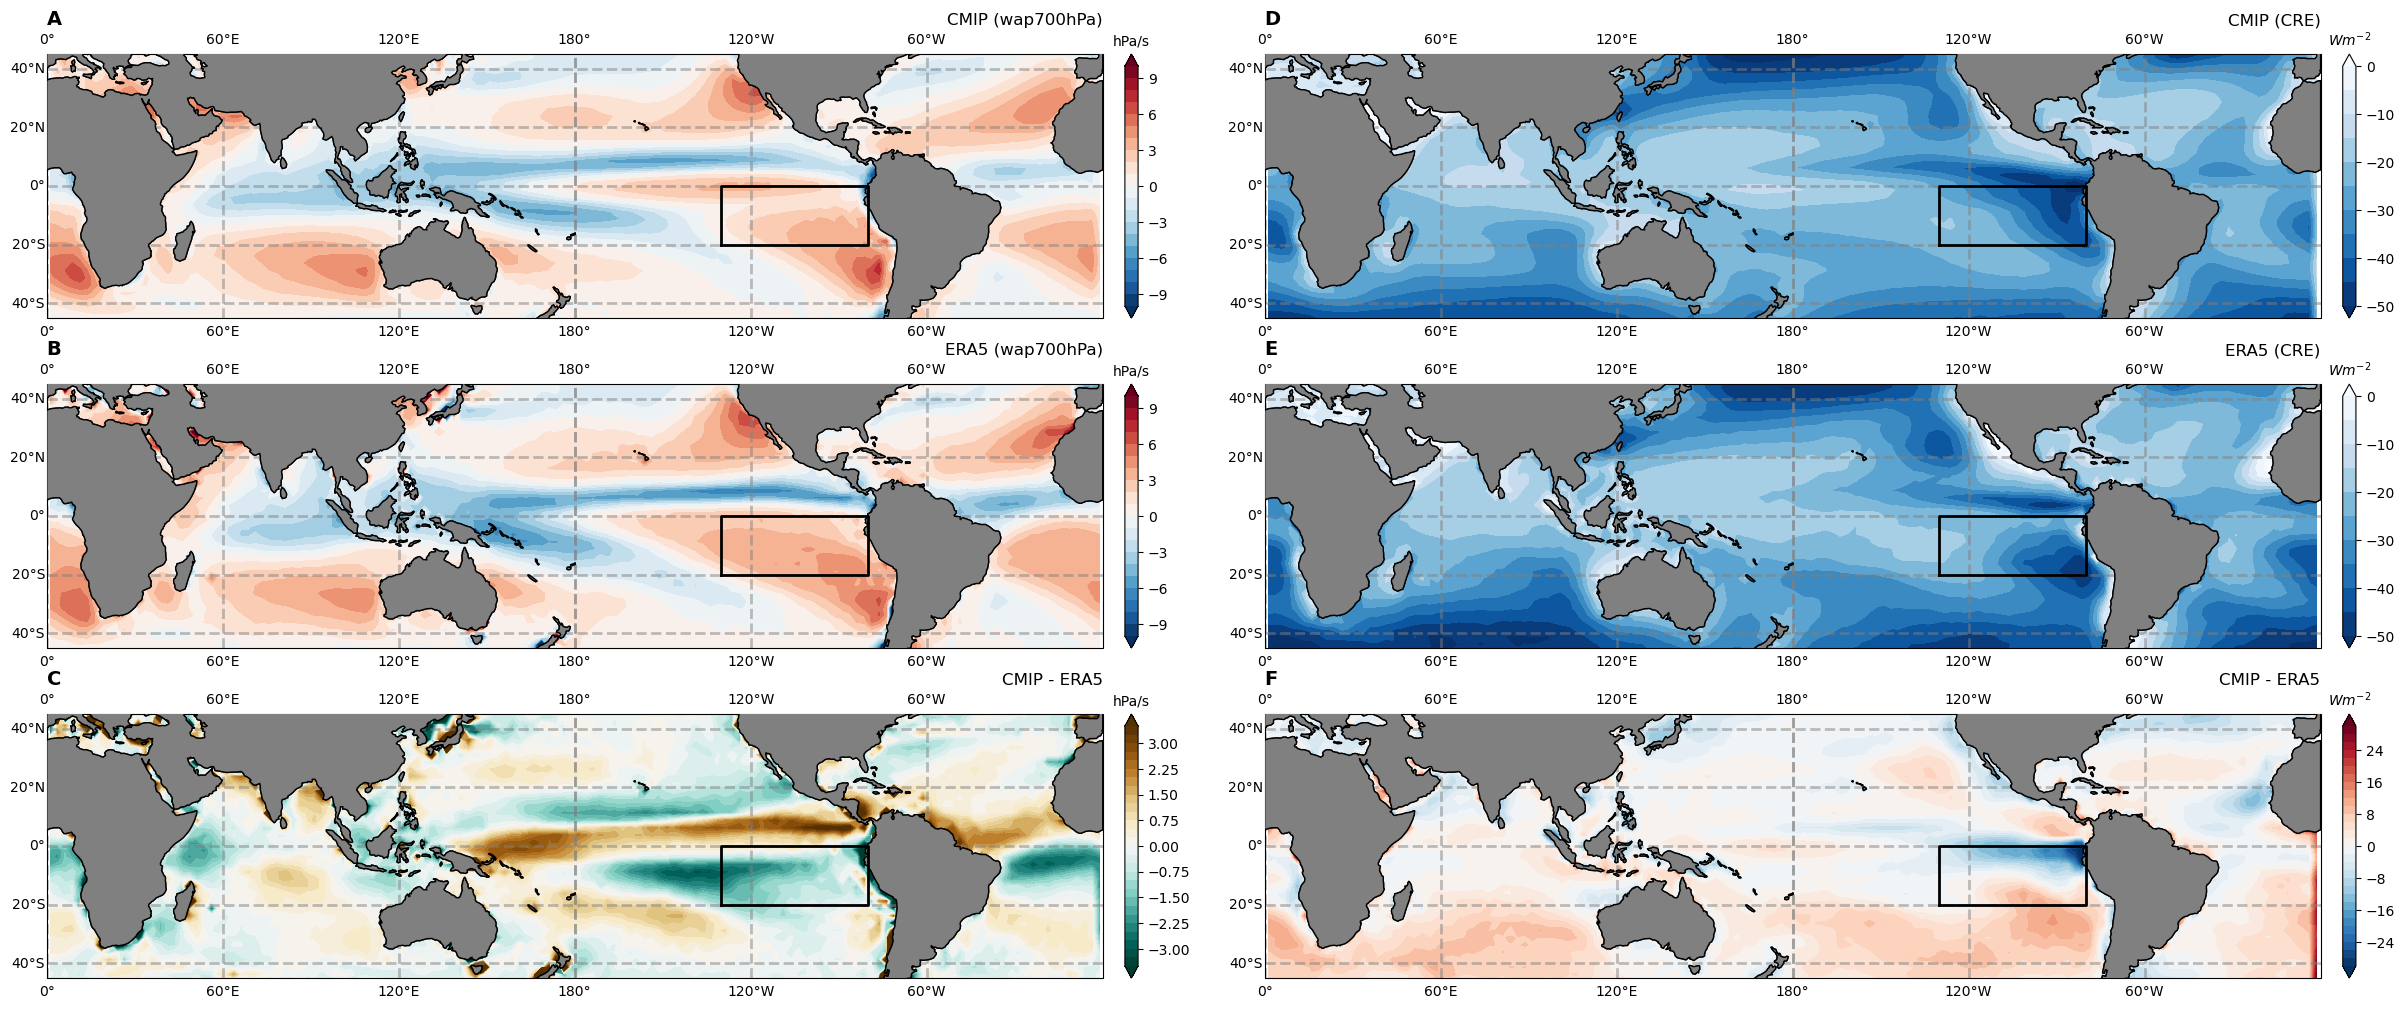

In [11]:
# Create figure and gridspec (3 rows, 2 columns)
fig = plt.figure(figsize=(30, 12))
gs = fig.add_gridspec(3, 2, hspace=0.25, wspace=0.10) 

######## LEFT COLUMN (wap 700hPa) ########
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180)) # CMIP wap700hPa
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180)) # ERA5 wap700hPa
ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=180)) # Difference (CMIP - ERA5)

######## RIGHT COLUMN (cre 700hPa) ########
ax4 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=180)) # CMIP CRE 700hPa
ax5 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=180)) # ERA5 CRE 700hPa
ax6 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=180)) # Difference (CMIP - ERA5)/ERA5

########### LEFT COLUMN: Precipitation ########
_global_plot(ax1, (100*cmip_wap700_clim["wap"].mean("model")).values, cmip_wap700_clim.lat, cmip_wap700_clim.lon, cmap="RdBu_r", cbar_label="hPa/s", levels=np.arange(-10, 11, 1))
ax1.set_title("CMIP (wap700hPa)", loc="right", fontsize=12)
ax1.set_title("A", loc="left", fontweight="bold", fontsize=14)

_global_plot(ax2, 100*era5_wap700_clim["wap"].values, era5_wap700_clim.lat, era5_wap700_clim.lon, cmap="RdBu_r", cbar_label="hPa/s", levels=np.arange(-10, 11, 1))
ax2.set_title("ERA5 (wap700hPa)", loc="right", fontsize=12)
ax2.set_title("B", loc="left", fontweight="bold", fontsize=14)

_global_plot(ax3, 100*(cmip_wap700_clim["wap"].mean("model").values - era5_wap700_clim["wap"].values),
             era5_wap700_clim.lat, era5_wap700_clim.lon, cmap="BrBG_r", cbar_label="hPa/s", levels=np.arange(-3.5, 3.75, .25))
ax3.set_title("CMIP - ERA5", loc="right", fontsize=12)
ax3.set_title("C", loc="left", fontweight="bold", fontsize=14)


########## RIGHT COLUMN: CRE #########
cmip_monthly_cre = cmip_monthly_swcre.values + cmip_monthly_lwcre.values
_global_plot(ax4, cmip_monthly_cre, cmip_monthly_swcre.lat, cmip_monthly_swcre.lon, cmap="Blues_r", cbar_label=r"$Wm^{-2}$", levels=np.arange(-50, 5, 5))
ax4.set_title("CMIP (CRE)", loc="right", fontsize=12)
ax4.set_title("D", loc="left", fontweight="bold", fontsize=14)

era5_cre_clim = era5_swcre_clim["swcre"].values/86400 + era5_lwcre_clim["lwcre"].values/86400
_global_plot(ax5, era5_cre_clim, era5_lwcre_clim.lat, era5_lwcre_clim.lon, cmap="Blues_r", cbar_label=r"$Wm^{-2}$", levels=np.arange(-50, 5, 5))
ax5.set_title("ERA5 (CRE)", loc="right", fontsize=12)
ax5.set_title("E", loc="left", fontweight="bold", fontsize=14)

_global_plot(ax6, (cmip_monthly_cre - era5_cre_clim), #/era5_cre_clim,
             cmip_monthly_lwcre.lat, cmip_monthly_lwcre.lon, cmap="RdBu_r", cbar_label=r"$Wm^{-2}$", levels=np.arange(-30, 32, 2))
ax6.set_title("CMIP - ERA5", loc="right", fontsize=12)
ax6.set_title("F", loc="left", fontweight="bold", fontsize=14)

#########################################################################
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_pr-bias_v2.png", dpi=300, bbox_inches="tight")
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_pr-bias_v2.pdf", dpi=300, bbox_inches="tight")